<a href="https://colab.research.google.com/github/Muanya/SchoolProject/blob/main/school_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import math
import time
import gc
from tqdm.notebook import tqdm; tqdm.pandas()

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


### CONV
>First lets encapsulate **2D Convolution** layer,  **Batch Normalization** layer and **activation** into a single block.


In [ ]:
@keras.utils.register_keras_serializable()
class Convn(keras.layers.Layer):
  def __init__(self, filters, kernel_size=1, strides=1, padding=None, groups=1,
                 act=True, name='_', deploy=False, **kwargs):
        super(Convn, self).__init__(name=name, **kwargs)
       
        self.deploy = deploy
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides
        self.groups = groups
        self.conv = keras.layers.Conv2D(filters, kernel_size, strides, padding='same', 
                               groups=groups, use_bias=False, name=f'cv')
        self.bn = keras.layers.BatchNormalization(name=f'bn') if not deploy else None
        self.act = keras.activations.swish if act is True else (act if isinstance(act, keras.acivations) else tf.identity)
            
  def call(self, x):
        return self.act(self.fused_conv(x)) if self.deploy else self.act(self.bn(self.conv(x)))
    
  def get_config(self):
        config = super(Convn, self).get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'padding':self.padding,
                       'strides': self.strides, 'groups': self.groups})
        return config
        
  

In [ ]:
def MP(name='MP',**kwargs):
    """wrapping maxpooling2D layer"""
    def layer(x):
        x = keras.layers.MaxPooling2D(name=f'{name}')(x)
        return x
    return layer


def AVP(name='AVP',**kwargs):
    """wrapping avgpooling2D layer"""
    def layer(x):
      x = keras.layers.AveragePooling2D((3, 3), strides=(2, 2), padding="valid", name=f'{name}')(x)
      return x
    return layer



def Dense(name='Dense',**kwargs):
    """wrapping Linear layer"""
    def layer(x):
      x = keras.layers.Dense(7, activation='softmax', name=f'{name}')(x)
      return x
    return layer

def Flatten(name='AVP',**kwargs):
    """wrapping flatten layer"""
    def layer(x):
      x = keras.layers.Flatten(name=f'{name}')(x)
      return x
    return layer

def Dropout(name='Dropout',**kwargs):
    """wrapping dropout layer"""
    def layer(x):
      x = keras.layers.Dropout(0.5, name=f'{name}')(x)
      return x
    return layer


In [ ]:
@keras.utils.register_keras_serializable()
class SPPCSPC(keras.layers.Layer):
     # CSP https://github.com/WongKinYiu/CrossStagePartialNetworks

    def __init__(self, filters, n=1, shortcut=False, groups=1, e=0.5, kernel_size=(5, 9, 13), name='SPPCSPC', deploy=False, **kwargs):
        super(SPPCSPC, self).__init__(name=name, **kwargs)
        c_ = int(2 * filters * e)  # hidden channels
        self.filters = filters
        self.n = n
        self.groups = groups
        self.e = e
        self.kernel_size = kernel_size
        self.deploy = deploy
        
        self.cv1 = Convn(c_, 1, 1, deploy=deploy, groups=groups, name=f'cv1')
        self.cv2 = Convn(c_, 1, 1, deploy=deploy, groups=groups, name=f'cv2')
        self.cv3 = Convn(c_, 3, 1, deploy=deploy, groups=groups, name=f'cv3')
        self.cv4 = Convn(c_, 1, 1, deploy=deploy, groups=groups, name=f'cv4')
        self.cv5 = Convn(filters, 1, 1, deploy=deploy, groups=groups, name=f'cv7') # transition layer
        self.m = [keras.layers.MaxPooling2D(pool_size=n, strides=1, padding='same', name=f'max_pool_{i}') for i, n in enumerate(kernel_size)]

    def call(self, x):
        x1 = self.cv1(x)
        spp_output = tf.concat([x1] + [m(x1) for m in self.m], axis=-1)
        csp_inp1 = self.cv3(self.cv4(spp_output)) # transition
        csp_inp2 = self.cv2(x)
        return self.cv5(tf.concat([csp_inp1, csp_inp2], axis=-1)) # concatenation and transition
    
    def get_config(self):
        config = super(SPPCSPC, self).get_config()
        config.update({'filters': self.filters, 'n': self.n, 'groups': self.groups,
                       'e': self.e, 'kernel_size':self.kernel_size})
        return config


In [ ]:
@keras.utils.register_keras_serializable()
class ResidualModule(keras.layers.Layer):
    def __init__(self, K, stride, chanDim=-1, red=True, reg=0.0001, bnEps=2e-5, bnMom=0.9, name='ResModule',  **kwargs):
      super(ResidualModule, self).__init__(name=name, **kwargs)
      self.K = K
      self.stride = stride
      self.chanDim = chanDim
      self.bnEps = bnEps
      self.bnMom = bnMom
      self.reg = reg
      self.red = red

      self.bn1 = keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps)
      self.bn2 = keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps)
      self.bn3 = keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps)
      self.act = keras.layers.Activation('relu')
      self.c1 = keras.layers.Conv2D(int(K / 4), (1, 1), use_bias=False,
                   kernel_regularizer=keras.regularizers.l2(reg))
      self.c2 = keras.layers.Conv2D(int(K / 4), (3, 3), strides=stride, use_bias=False, padding='same',
                   kernel_regularizer=keras.regularizers.l2(reg))
      self.c3 = keras.layers.Conv2D(int(K), (1, 1), use_bias=False,
                   kernel_regularizer=keras.regularizers.l2(reg))
      self.c4 = keras.layers.Conv2D(K, (1, 1), strides=stride, use_bias=False,
                              kernel_regularizer=keras.regularizers.l2(reg))
      self.add = keras.layers.Add()


    def call(self, data):
        shortcut = data

        # first block of resModule -- Dimensionality reduction
        bn = self.bn1(data)
        act = self.act(bn)
        # conv layer with kernel size (1, 1)
        x = self.c1(act)

        # second block of resModule -- Applying the convolution
        bn = self.bn2(x)
        act = self.act(bn)
        # conv layer with kernel size (3, 3)
        x = self.c2(act)

        # Third block of resModule -- Dimensionality incrementation
        bn = self.bn3(x)
        act = self.act(bn)
        # conv layer with kernel size (1, 1)
        x = self.c3(act)

        if self.red:
            shortcut = self.c4(shortcut)

            # add together the shortcut and the final CONV
        x = self.add([x, shortcut])

        return x

    def get_config(self):
      config = super(ResidualModule, self).get_config()
      config.update({'K': self.K, 'stride': self.stride, 'chanDim': self.chanDim,
                      'reg': self.reg, 'bnEps':self.bnEps, 'bnMom': self.bnMom})
      return config


In [ ]:
@keras.utils.register_keras_serializable()
class custom_fit(keras.Model):
    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            outputs = self(images, training=True) # forward pass 
            reg_loss = tf.reduce_sum(self.losses)
            pred_loss = self.loss(labels, outputs)
            total_loss = tf.reduce_sum(pred_loss) + reg_loss
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        avg_loss.update_state(total_loss)
        return {"loss": avg_loss.result()}
    
    @property
    def metrics(self):
        return [avg_loss]
    
    def test_step(self, data):
        images, labels = data
        outputs = self(images) # forward pass 
        reg_loss = tf.reduce_sum(self.losses)
        pred_loss = loss(labels, outputs)
        total_loss = tf.reduce_sum(pred_loss) + reg_loss
        avg_loss.update_state(total_loss)
        return {"val_loss": avg_loss.result()}
        
    def get_config(self):
        config = super(custom_fit, self).get_config()
        return config

In [ ]:
# cfg = {
#     'layers': [
#   [-1, 1, 'Convn', [64, 7, 2]],
#   [-1, 1, 'ResidualModule', [128, 1]],
#   [-1, 1, 'ResidualModule', [128, 1]],
#   [-1, 1, 'MP', []],
#   [-1, 1, 'ResidualModule', [256, 1]],
#   [-1, 1, 'ResidualModule', [256, 1]],
#   [-1, 1, 'SPPCSPC', [512]],
#   [-1, 1, 'Convn', [1024, 3, 1]],
#   [-1, 1, 'AVP', []],
#   [-1, 1, 'Flatten', []],
#   [-1, 1, 'Dropout', []],
#   [-1, 1, 'Dense', []],
#     ]
# }


cfg = {
    'layers': [
  [-1, 1, 'Convn', [64, 7, 2]],
  [-1, 1, 'ResidualModule', [128, 1]],
  [-1, 1, 'MP', []],
  [-1, 1, 'ResidualModule', [256, 1]],
  [-1, 1, 'SPPCSPC', [512]],
  [-1, 1, 'Convn', [1024, 3, 1]],
  [-1, 1, 'AVP', []],
  [-1, 1, 'Flatten', []],
  [-1, 1, 'Dropout', []],
  [-1, 1, 'Dense', []],
    ]
}

In [ ]:
def build_model(cfg):
  input_shape=(48, 48, 3)
  input_ = keras.Input(shape=input_shape)
  output = []
  for idx, values, in enumerate(cfg['layers']):
    f, n, block, arg = values
    output.append(
        eval(f'{block}')(*arg, name=f'{idx}_{block}')(
              input_ if len(output)==0 else output[f])
        )

  
  # model = custom_fit(inputs=input_, outputs=output[-1], name=f'spp_res')
  model = keras.Model(inputs=input_, outputs=output[-1], name=f'spp_res')
  return model 

In [ ]:
model = build_model(cfg)
model.summary()

Model: "spp_res"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 0_Convn (Convn)             (None, 24, 24, 64)        9664      
                                                                 
 1_ResidualModule (ResidualM  (None, 24, 24, 128)      24064     
 odule)                                                          
                                                                 
 2_MP (MaxPooling2D)         (None, 12, 12, 128)       0         
                                                                 
 3_ResidualModule (ResidualM  (None, 12, 12, 256)      95232     
 odule)                                                          
                                                                 
 4_SPPCSPC (SPPCSPC)         (None, 12, 12, 512)       4204

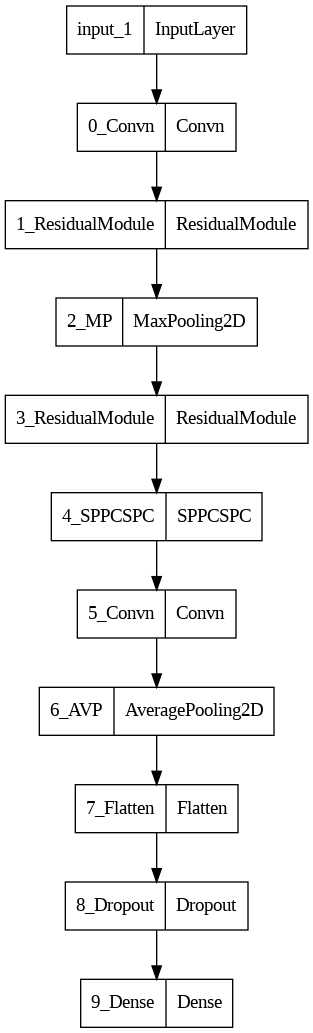

In [ ]:
keras.utils.plot_model(model, to_file='tmp.png', show_shapes=False)

In [ ]:
# model1 = ResidualModule()
# keras.utils.plot_model(model1, to_file='tmp.png', show_shapes=False)


In [ ]:
loss = keras.losses.CategoricalCrossentropy()
avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!cd drive/MyDrive/project_material/

In [ ]:
import datetime
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
KEY_DICT = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
            4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


def load_file():
  filename = 'drive/MyDrive/project_material/train.csv'
  return pd.read_csv(filename)
  


def process(train):
    train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1, 48, 48)
                       for x in train['pixels']]
    x = np.concatenate(train.pixels)
    y = train.emotion.values

    # normalize the training images 
    x = x.astype('float32') / 255
    # split the train set
    X_train, X_valid, y_train, y_valid = train_test_split(
        x, y, random_state=1, stratify=y, train_size=0.85,
    )

    # Repeat the layer of the grayscale image to form 3 layers
    rgb_X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
    rgb_X_valid = np.repeat(X_valid[..., np.newaxis], 3, -1)

    # Uncomment for one hot encoding
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)

    return [rgb_X_train, rgb_X_valid, y_train, y_valid]


def augument_data(x, y):
      # apply image augumentation to the training set 
      datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.3,
      height_shift_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='reflect')
      loader = datagen.flow(x, y, batch_size=64)
      return loader



def train_model(model, train_loader, valid_x, valid_y):
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    h1 = model.fit(
        train_loader,
        batch_size=32,
        epochs=120,
        verbose=1,
        validation_data=(valid_x, valid_y),
        callbacks=[tb],
    )

    history = h1.history
    save_current_model(model, history)
    visualize_history(history)


def visualize_history(history):
    epoch_range = range(1, len(history['loss']) + 1)

    plt.figure(figsize=[14, 4])
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, history['loss'], label='Training')
    plt.plot(epoch_range, history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, history['accuracy'], label='Training')
    plt.plot(epoch_range, history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


def save_current_model(model, history):
    print("=============== Saving Model ================")
    # model_name = f'trained_model/fer_model_v02.h5'
    # history_file = f'model_history/fer_v02.pkl'
    model_name = f'fer_model2.h5'
    history_file = f'fer_v2.pkl'
    model.save(model_name)
    pickle.dump(history, open(history_file, 'wb'))


def visualize(train):
    sz = 20
    fig = plt.figure(figsize=(10, 7))
    rw = sz // 2
    cl = sz - rw
    for ind, row in train.iterrows():
        fig.add_subplot(rw, cl, ind + 1)
        plt.imshow(row['pixels'], cmap='gray')
        plt.axis('off')
        emotion = KEY_DICT[row['emotion']]
        plt.title(f'{emotion}')

        if ind >= sz - 1:
            break
    plt.subplots_adjust(hspace=1.5)
    plt.show()



In [ ]:
train = load_file()

train.head()


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
X_train, X_val, y_train, y_val = process(train)

print(len(X_train))
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

24402
(24402, 48, 48, 3)
(4307, 48, 48, 3)
(24402, 7)
(4307, 7)


In [ ]:
train_loader = augument_data(X_train, y_train)

Epoch 1/120
382/382 [==============================] - 69s 134ms/step - loss: 2.0375 - accuracy: 0.2251 - val_loss: 1.9482 - val_accuracy: 0.1779
Epoch 2/120
382/382 [==============================] - 52s 137ms/step - loss: 1.8538 - accuracy: 0.2612 - val_loss: 1.7931 - val_accuracy: 0.2858
Epoch 3/120
382/382 [==============================] - 54s 141ms/step - loss: 1.8239 - accuracy: 0.2761 - val_loss: 1.8727 - val_accuracy: 0.2691
Epoch 4/120
382/382 [==============================] - 53s 138ms/step - loss: 1.8005 - accuracy: 0.2938 - val_loss: 1.7916 - val_accuracy: 0.3035
Epoch 5/120
382/382 [==============================] - 52s 135ms/step - loss: 1.7859 - accuracy: 0.3009 - val_loss: 1.8177 - val_accuracy: 0.2840
Epoch 6/120
382/382 [==============================] - 52s 136ms/step - loss: 1.7636 - accuracy: 0.3119 - val_loss: 1.8587 - val_accuracy: 0.3049
Epoch 7/120
382/382 [==============================] - 54s 141ms/step - loss: 1.7412 - accuracy: 0.3250 - val_loss: 1.6837 -

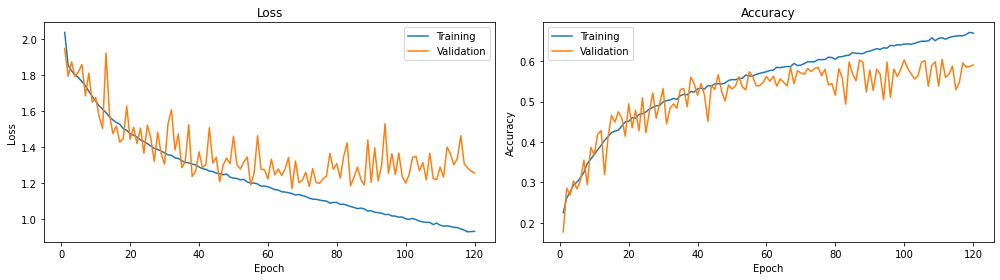

In [23]:
train_model(model, train_loader, X_val, y_val)

In [ ]:
filename = 'drive/MyDrive/project_material/train.csv'
train = pd.read_csv(filename)

In [ ]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
layer_outputs = [layer.output for layer in model.layers]

In [ ]:
feature_map_model = keras.Model(input=model.input, output=layer_outputs)